In [23]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.inspection import permutation_importance

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

import warnings

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_wine
import optuna

In [24]:
# print input files
input_path = os.getcwd() + "/input"

In [25]:
# loading pizza data
data_path = input_path + "/pizza.csv"
pizza = pd.read_csv(data_path)

In [26]:
# clean up postal code
pizza['postalCode'] = pizza['postalCode'].astype(str)
pizza = pizza[pizza.postalCode != "nan"]
pizza = pizza[pizza["menus.amountMax"] < 100.0]
    
for i,j in enumerate(pizza['postalCode']):    
    # get rid of '-' postal code suffix
    if "-" in j:
        pizza['postalCode'][i] = pizza['postalCode'][i].split("-")[0]

In [27]:
# loading income data
data_path = input_path + "/income.csv"
income = pd.read_csv(data_path,engine='python',encoding='latin1')
income['Zip_Code'] = income['Zip_Code'].astype(str)

In [28]:
# join both datasets
pizza_df = pd.DataFrame(pizza)
pizza_df = pizza_df.set_index("postalCode")

income_df = pd.DataFrame(income[["Zip_Code", "Median"]])
income_df = income_df.set_index("Zip_Code")
complete_df = pizza_df.join(income_df, on='postalCode')

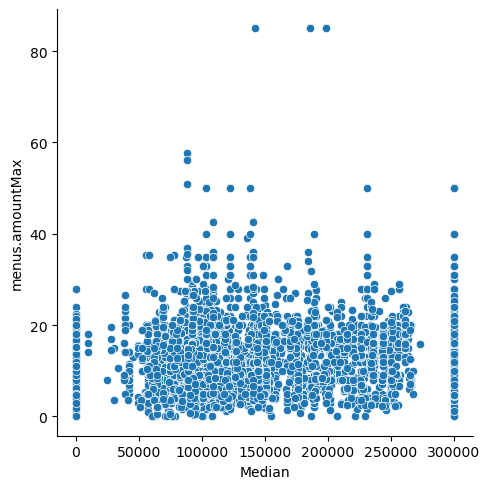

In [29]:
sns.relplot(data=complete_df, x=complete_df["Median"], y=complete_df["menus.amountMax"])

In [30]:
# create master pipeline
data_pipeline = ColumnTransformer(
    transformers=[('imputer', SimpleImputer(strategy='mean'), ['Median']),
                  ('ord1', OrdinalEncoder(), ['province']),
                  ('ord2', OrdinalEncoder(), ['primaryCategories']),
                  ('ord3', OrdinalEncoder(), ['city']),],
    remainder='passthrough')
data_pipeline.set_output(transform="pandas")

df_processed = data_pipeline.fit_transform(complete_df)
df_processed.drop(columns=['remainder__menuPageURL','remainder__menus.description', 'remainder__id', 
                           'remainder__address', 'remainder__country', 'remainder__keys', 
                           'remainder__menus.currency', 'remainder__priceRangeCurrency', 'remainder__name',
                           'remainder__dateAdded', 'remainder__dateUpdated', 'remainder__menus.dateSeen'
                          ], inplace=True)
df_processed.drop(columns=['remainder__categories', 'remainder__menus.name',], inplace=True)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11259 entries, 72120 to 89128
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   imputer__Median             11259 non-null  float64
 1   ord1__province              11259 non-null  float64
 2   ord2__primaryCategories     11259 non-null  float64
 3   ord3__city                  11259 non-null  float64
 4   remainder__latitude         11259 non-null  float64
 5   remainder__longitude        11259 non-null  float64
 6   remainder__menus.amountMax  11259 non-null  float64
 7   remainder__menus.amountMin  11259 non-null  float64
 8   remainder__priceRangeMin    11259 non-null  int64  
 9   remainder__priceRangeMax    11259 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 1.2+ MB


In [31]:
# split model
X, y = df_processed[df_processed.columns.difference(['remainder__menus.amountMax'])], df_processed[['remainder__menus.amountMax']]

X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, test_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=42)

In [32]:
# RandomForestRegressor model
rf = RandomForestRegressor()
rf.fit(X_val, y_val.values.ravel())

prediction = rf.predict(X_test)
r2_score(y_test, prediction)

0.9157625474007002

In [33]:
# Hyperparameter tuning
param_dist = {"max_depth": [3, 5], 
    "max_features": sp_randint(1, 11), 
    "min_samples_split": sp_randint(2, 11), 
    "bootstrap": [True, False], 
    "criterion": ['friedman_mse', 'poisson', 'absolute_error', 'squared_error']} 

rf = RandomForestRegressor()

# Randomized search
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
    n_iter=2, cv=2) 
random_search.fit(X_train, y_train.values.ravel())
hyperparams = random_search.best_params_

In [34]:
# train model
rf = RandomForestRegressor(**hyperparams)
rf.fit(X_val, y_val.values.ravel())

prediction = rf.predict(X_test)
r2_score(y_test, prediction)

0.8707149573248221

In [35]:
prediction = rf.predict(X_test)
mse = mean_squared_error(y_test, prediction)
rmse = mse**.5
print(mse)
print(rmse)


7.112367077094528
2.666902149891242


In [36]:
df_processed['remainder__menus.amountMax'].describe()

count    11259.000000
mean        13.498888
std          7.027170
min          0.000000
25%          8.450000
50%         13.000000
75%         17.950000
max         88.000000
Name: remainder__menus.amountMax, dtype: float64

In [37]:
y_test_mean = [np.mean(y_test)]*len(y_test)
mse = mean_squared_error(y_test, y_test_mean)
rmse = mse**.5
print(mse)
print(rmse)

55.013069802389985
7.4170796006507835


In [38]:
# build second model with xg_boost
#hide warnings
warnings.filterwarnings('ignore')

model = XGBRegressor()
model.fit(X_val, y_val)

# R^2 value for xg_boost model
prediction = model.predict(X_test)
r2_score(y_test, prediction)

0.9291355723078474

In [39]:
# hyperparameter tuning of XGBoost

# optuna objective function
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBRegressor(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    prediction = model.predict(X_test)

    # Evaluate predictions
    accuracy = r2_score(y_test, prediction)
    return accuracy

# optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# print best parameters
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-05-06 12:48:54,484] A new study created in memory with name: no-name-f93e105f-0627-47d4-9625-8e41dce89336
[I 2023-05-06 12:48:54,794] Trial 0 finished with value: 0.9291355723078474 and parameters: {'max_depth': 3, 'learning_rate': 0.10780418987917599, 'n_estimators': 337, 'min_child_weight': 10, 'gamma': 2.91993431493888e-08, 'subsample': 0.3126253566494766, 'colsample_bytree': 0.5187957936995086, 'reg_alpha': 3.616176914744209e-08, 'reg_lambda': 0.019326222089801785}. Best is trial 0 with value: 0.9291355723078474.
[I 2023-05-06 12:48:55,116] Trial 1 finished with value: 0.9291355723078474 and parameters: {'max_depth': 8, 'learning_rate': 0.10776223460688625, 'n_estimators': 261, 'min_child_weight': 7, 'gamma': 0.00045494634511572015, 'subsample': 0.8537771457652954, 'colsample_bytree': 0.032520797237978134, 'reg_alpha': 1.9694785642602652e-05, 'reg_lambda': 0.4700090412791474}. Best is trial 0 with value: 0.9291355723078474.
[I 2023-05-06 12:48:55,403] Trial 2 finished with 

Number of finished trials: 100
Best trial:
  Value: 0.9291355723078474
  Params: 
    max_depth: 3
    learning_rate: 0.10780418987917599
    n_estimators: 337
    min_child_weight: 10
    gamma: 2.91993431493888e-08
    subsample: 0.3126253566494766
    colsample_bytree: 0.5187957936995086
    reg_alpha: 3.616176914744209e-08
    reg_lambda: 0.019326222089801785


In [40]:
# refit model
params = trial.params
model = XGBRegressor(**params)
model.fit(X_val, y_val)

# R^2 value for xg_boost model
prediction = model.predict(X_test)
r2_score(y_test, prediction)

0.869677407232486

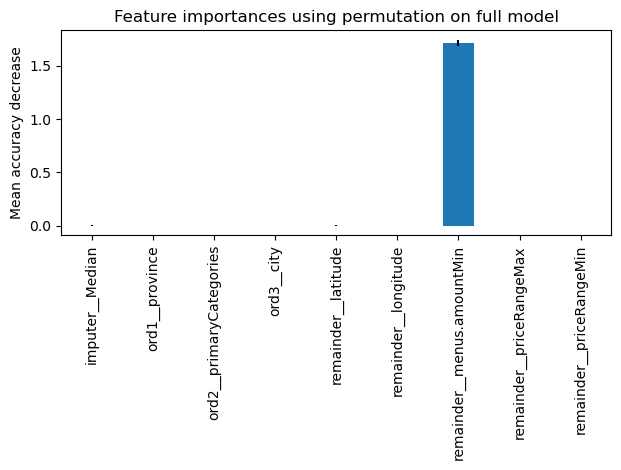

In [41]:
# determining feature importance 
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

# feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns
importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

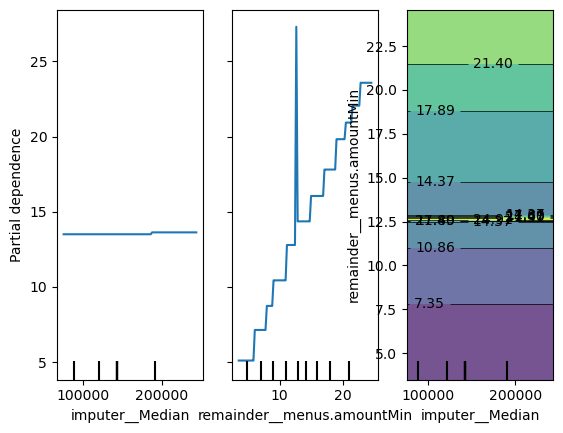

In [42]:
# plot partial dependency plot 
features = [0, 6, (0,6)]
PartialDependenceDisplay.from_estimator(rf, X, features)

In [43]:
# train new model without remainder_menus.amountMin
df_processed.drop(columns=['remainder__menus.amountMin',], inplace=True)

# split model
X, y = df_processed[df_processed.columns.difference(['remainder__menus.amountMax'])], df_processed[['remainder__menus.amountMax']]

X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, test_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=42)

# train model
rf = RandomForestRegressor()
rf.fit(X_train, y_train.values.ravel())

prediction = rf.predict(X_val)
print(r2_score(y_val, prediction))

0.16280605839003504


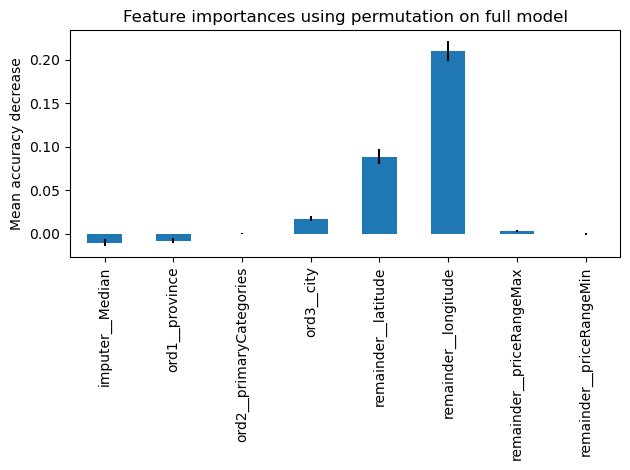

In [44]:
# determining feature importance w/o remainder__princeRangeMax
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

# feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns
importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# shows that the model needs menu amountMin to have accurate prediction, or else it's dependent on it's coordinate 
# but it wasn't that accurate